In [349]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [350]:
device=torch.device("cuda")

import numpy as np
train_st=np.load('./processed_data/station/train.npy')
train_lab=np.load('./processed_data/labels/train_labels.npy')
test_st=np.load('./processed_data/station/test.npy')
test_lab=np.load('./processed_data/labels/test_labels.npy')
no2_train_sat=np.load('./processed_data/no2_train.npy')
o3_test_sat=np.load('./processed_data/o3_test.npy')
no2_test_sat=np.load('./processed_data/no2_test.npy')
o3_train_sat=np.load('./processed_data/o3_train.npy')



In [351]:
print(no2_train_sat.shape,o3_train_sat.shape)

# satellite=np.stack((no2_train_sat,o3_train_sat),axis=0)
satellite=o3_train_sat
satellite=torch.tensor(satellite,dtype=torch.float32).to(device)
satellite_hourly=torch.repeat_interleave(satellite,24,dim=0)
satellite_hourly=satellite_hourly.unsqueeze(0)
satellite_hourly.shape

(730, 9, 10) (730, 9, 10)


torch.Size([1, 17520, 9, 10])

In [352]:
# test_satellite=np.stack((no2_test_sat,o3_test_sat),axis=0)
test_satellite=o3_test_sat
test_satellite=torch.tensor(test_satellite,dtype=torch.float32).to(device)
test_satellite_hourly=torch.repeat_interleave(test_satellite,24,dim=0)
test_satellite_hourly=test_satellite_hourly.unsqueeze(0)
test_satellite_hourly.shape

torch.Size([1, 8784, 9, 10])

In [353]:
station=torch.tensor(train_st,dtype=torch.float32).to(device)
print(station.shape)

labels=torch.tensor(train_lab,dtype=torch.float32).to(device)
labels=labels[12:]
# labels=labels[:,1]
# labels=labels.unsqueeze(1)
print(labels.shape)

satellite_hourly_seq=satellite_hourly.unfold(dimension=1,size=12,step=1).permute(1,4,0,2,3)
station_seq=station.unfold(dimension=0,size=12,step=1)
satellite_hourly_seq=satellite_hourly_seq[:-1,...]
station_seq=station_seq[:-1,...]
station_seq=station_seq.permute(0,2,1)
print(satellite_hourly_seq.shape)
print(station_seq.shape)


torch.Size([17520, 18])
torch.Size([17508, 2])
torch.Size([17508, 12, 1, 9, 10])
torch.Size([17508, 12, 18])


In [354]:
test_station=torch.tensor(test_st,dtype=torch.float32).to(device)
print(test_station.shape)

test_labels=torch.tensor(test_lab,dtype=torch.float32).to(device)
test_labels=test_labels[12:]
test_labels=test_labels[:,1]
test_labels=test_labels.unsqueeze(1)
print(test_labels.shape)

test_satellite_hourly_seq=test_satellite_hourly.unfold(dimension=1,size=12,step=1).permute(1,4,0,2,3)
test_station_seq=test_station.unfold(dimension=0,size=12,step=1)
test_satellite_hourly_seq=test_satellite_hourly_seq[:-1,...]
test_station_seq=test_station_seq[:-1,...]
test_station_seq=test_station_seq.permute(0,2,1)
print(test_satellite_hourly_seq.shape)
print(test_station_seq.shape)


torch.Size([8784, 18])
torch.Size([8772, 1])
torch.Size([8772, 12, 1, 9, 10])
torch.Size([8772, 12, 18])


O3 (scaled/ raw?) count: 17520 mean: 37.78931027879316 std: 40.67765621576998 median: 20.3 skew: 1.4857376758711054
NO2 count: 17520 mean: 56.69669340988012 std: 26.743681630223097 median: 50.2 skew: 1.4616191571587567


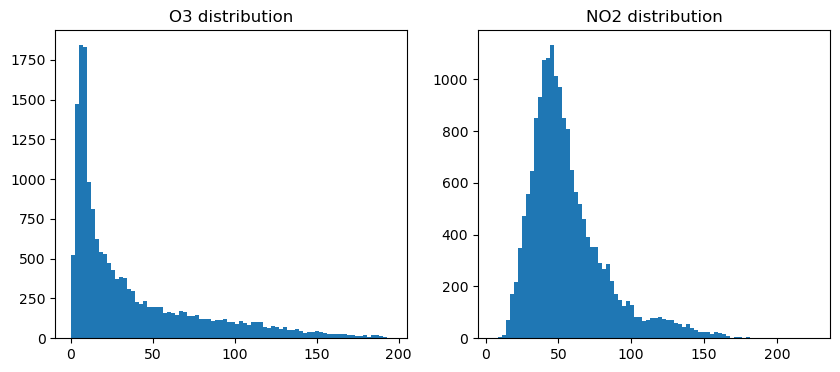

In [355]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# labels: torch.Tensor shape [N, 2] scaled (z-score) or raw
labels_np = train_lab# assume labels is torch Tensor
o3 = labels_np[:, 1]    # if your ordering is [NO2, O3]
no2 = labels_np[:, 0]

def summary(arr, name="var"):
    print(name, "count:", arr.size,
          "mean:", np.mean(arr),
          "std:", np.std(arr),
          "median:", np.median(arr),
          "skew:",  np.mean(((arr - arr.mean())/arr.std())**3))

summary(o3, "O3 (scaled/ raw?)")
summary(no2, "NO2")

# histogram
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(o3, bins=80)
plt.title("O3 distribution")
plt.subplot(1,2,2)
plt.hist(no2, bins=80)
plt.title("NO2 distribution")
plt.show()

In [356]:
o3_log = np.log1p(train_lab[:,1])        # stabilizes variance, reduces skew
o3_scaled = (o3_log - o3_log.mean()) / o3_log.std()

In [357]:
testo3_log=np.log1p(test_lab[:,1])
testo3_scaled=(testo3_log-o3_log.mean()) / o3_log.std()

In [358]:
no2_raw=train_lab[:,0]
no2_scaled = (no2_raw - no2_raw.mean()) / no2_raw.std()
labels_scaled = np.stack((no2_scaled,o3_scaled),axis=0)

labels_scaled=torch.tensor(labels_scaled).to(device).permute(1,0)

labels_scaled=labels_scaled[12:]
print(labels_scaled.shape)

torch.Size([17508, 2])


In [359]:
testno2_raw=test_lab[:,0]
testno2_scaled = (testno2_raw - no2_raw.mean()) / no2_raw.std()

testlabels_scaled = np.stack((testno2_scaled,testo3_scaled),axis=0)

testlabels_scaled=torch.tensor(testlabels_scaled).to(device).permute(1,0)

testlabels_scaled=testlabels_scaled[12:]
print(testlabels_scaled.shape)

torch.Size([8772, 2])


In [360]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNEncoder(nn.Module):
    """Encodes spatial satellite grids into a compact feature vector, with channel attention."""
    def __init__(self, in_channels=2, output_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Attention block (Squeeze-and-Excitation)
        self.attn_fc1 = nn.Linear(in_channels, in_channels // 2)
        self.attn_fc2 = nn.Linear(in_channels // 2, in_channels)

        # NOTE: flatten size depends on input H×W
        self.flatten_size = 32 * (9 // 2) * (10 // 2)  # after pooling
        self.fc = nn.Linear(self.flatten_size, output_size)

    def forward(self, x):
        # x: [batch, channels=2, H, W]

        # ---- Channel Attention ----
        # Global avg pooling across H×W → [batch, channels]
        attn = x.mean(dim=(2, 3))  
        attn = F.relu(self.attn_fc1(attn))
        attn = torch.sigmoid(self.attn_fc2(attn))  # [batch, channels]

        # Reshape & reweight input channels
        attn = attn.unsqueeze(-1).unsqueeze(-1)    # [batch, channels, 1, 1]
        x = x * attn                               # scale each channel

        # ---- CNN encoding ----
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        return torch.tanh(self.fc(x))
class LinearEncoder(nn.Module):
    """Flattens spatial grid directly to a feature vector (baseline encoder)."""
    def __init__(self, in_channels=2, grid_size=(9, 10), output_size=32):
        super().__init__()
        input_size = in_channels * grid_size[0] * grid_size[1]
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.fc(x)

class Attention(nn.Module):
    """Applies attention over LSTM outputs."""
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1)  # score per timestep

    def forward(self, lstm_out):
        # lstm_out: [batch, seq_len, hidden_size]
        scores = self.attn(lstm_out).squeeze(-1)        # [batch, seq_len]
        weights = torch.softmax(scores, dim=1)          # attention weights
        context = torch.bmm(weights.unsqueeze(1), lstm_out)  # [batch, 1, hidden_size]
        return context.squeeze(1), weights              # [batch, hidden_size], [batch, seq_len]
    
class FusionModel(nn.Module):
    """Fuses CNN-encoded satellite data with station features, then forecasts pollutants."""
    def __init__(
        self,
        sat_channels=2,
        station_features=18,
        cnn_out=64,
        lstm_hidden=64,
        lstm_layers=1,
        dropout=0.15
    ):
        super().__init__()

        # Choose encoder
        self.cnn = CNNEncoder(in_channels=sat_channels, output_size=cnn_out)
        # self.cnn = LinearEncoder(in_channels=sat_channels, output_size=cnn_out)

        lstm_input_size = cnn_out + station_features
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.attn = Attention(lstm_hidden)
        
        self.no2_adapter = nn.Sequential(nn.Linear(lstm_hidden, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU())
        self.o3_adapter  = nn.Sequential(nn.Linear(lstm_hidden, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU())

        # Heads for O3 and NO2
        self.head_O3 = nn.Linear(32, 1)
        self.head_NO2 = nn.Linear(32, 1)

    def forward(self, sat_x, station_x):
        """
        sat_x: [batch, seq_len, channels, H, W]
        station_x: [batch, seq_len, station_features]
        """
        batch_size, seq_len, _, _, _ = sat_x.shape

        # Encode each time step
        cnn_embeds = []
        for t in range(seq_len):
            sat_frame = sat_x[:, t]  # [batch, channels, H, W]
            cnn_embeds.append(self.cnn(sat_frame))
        cnn_embeds = torch.stack(cnn_embeds, dim=1)  # [batch, seq_len, cnn_out]

        # Fuse with station features
        lstm_in = torch.cat((cnn_embeds, station_x), dim=2)

        # Temporal modeling
        lstm_out, (hn, cn) = self.lstm(lstm_in)
        
        context, weights = self.attn(lstm_out) 

        o3_feat = self.o3_adapter(context)
        no2_feat = self.no2_adapter(context)
        pred_o3 = self.head_O3(o3_feat)
        pred_no2 = self.head_NO2(no2_feat)
        # # Predict O3 and NO2
        # pred_o3 = self.head_O3(final_state)
        # pred_no2 = self.head_NO2(final_state)

        return torch.cat((pred_no2, pred_o3), dim=1)  # [batch, 2]



In [361]:
import torch.optim as optim

sat_data=satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=station_seq #[17508, 16, 12]
labels=labels_scaled # ([17508, 2])
# Create Dataset and DataLoader
dataset = TensorDataset(sat_data, station_data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ======================
# Init model + optimizer
# ======================
model = FusionModel(
    sat_channels=1,
    station_features=18,   # match your station features
    cnn_out=64,
    lstm_hidden=128,
    lstm_layers=5,
    dropout=0.15
).to(device)

criterion = nn.MSELoss()       # regression forecasting
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# ====================
# Training Loop
# ====================
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for sat_batch, station_batch, y_batch in dataloader:
        sat_batch = sat_batch.to(device, dtype=torch.float32)
        station_batch = station_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(sat_batch, station_batch)  # [batch, 2]

        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * sat_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

/home/wolverine/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch [1/50] Loss: 0.5882
Epoch [2/50] Loss: 0.3155
Epoch [3/50] Loss: 0.2494
Epoch [4/50] Loss: 0.1897
Epoch [5/50] Loss: 0.1497
Epoch [6/50] Loss: 0.1368
Epoch [7/50] Loss: 0.1272
Epoch [8/50] Loss: 0.1189
Epoch [9/50] Loss: 0.1144
Epoch [10/50] Loss: 0.1102
Epoch [11/50] Loss: 0.1085
Epoch [12/50] Loss: 0.1053
Epoch [13/50] Loss: 0.0995
Epoch [14/50] Loss: 0.0982
Epoch [15/50] Loss: 0.0956
Epoch [16/50] Loss: 0.0918
Epoch [17/50] Loss: 0.0901
Epoch [18/50] Loss: 0.0884
Epoch [19/50] Loss: 0.0861
Epoch [20/50] Loss: 0.0832
Epoch [21/50] Loss: 0.0800
Epoch [22/50] Loss: 0.0803
Epoch [23/50] Loss: 0.0768
Epoch [24/50] Loss: 0.0737
Epoch [25/50] Loss: 0.0709
Epoch [26/50] Loss: 0.0688
Epoch [27/50] Loss: 0.0701
Epoch [28/50] Loss: 0.0665
Epoch [29/50] Loss: 0.0648
Epoch [30/50] Loss: 0.0629
Epoch [31/50] Loss: 0.0613
Epoch [32/50] Loss: 0.0589
Epoch [33/50] Loss: 0.0586
Epoch [34/50] Loss: 0.0565
Epoch [35/50] Loss: 0.0551
Epoch [36/50] Loss: 0.0524
Epoch [37/50] Loss: 0.0513
Epoch [38/

In [362]:
import torch


def evaluate(model, dataloader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in dataloader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds = model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    metrics = {}
    for i, name in enumerate(["NO2","O3"]):
        y_true = labels_all[:, i]
        y_pred = preds_all[:, i]

        mse = torch.mean((y_true - y_pred) ** 2).item()
        rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
        mae = torch.mean(torch.abs(y_true - y_pred)).item()

        # R² = 1 - SS_res / SS_tot
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float("nan")

        metrics[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2.item() if isinstance(r2, torch.Tensor) else r2
        }

    return metrics


In [363]:
sat_data=test_satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=test_station_seq #[17508, 16, 12]
# test_labels_scaled = (test_labels - labels_mean) / labels_std
labels=testlabels_scaled # ([17508, 2])

test_dataset = TensorDataset(sat_data, station_data, labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



val_metrics = evaluate(model, test_loader, device)

print(f"O3  → MSE: {val_metrics['O3']['MSE']:.2f}, "
      f"RMSE: {val_metrics['O3']['RMSE']:.2f}, "
      f"MAE: {val_metrics['O3']['MAE']:.2f}, "
      f"R2: {val_metrics['O3']['R2']:.3f}")

print(f"NO2 → MSE: {val_metrics['NO2']['MSE']:.2f}, "
      f"RMSE: {val_metrics['NO2']['RMSE']:.2f}, "
      f"MAE: {val_metrics['NO2']['MAE']:.2f}, "
      f"R2: {val_metrics['NO2']['R2']:.3f}")


O3  → MSE: 0.59, RMSE: 0.77, MAE: 0.58, R2: 0.351
NO2 → MSE: 0.17, RMSE: 0.41, MAE: 0.29, R2: 0.865


In [366]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in test_loader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds = model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate across all batches
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    # ====== Plot for O3 ======
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(labels_all[:, 0], preds_all[:, 0], alpha=0.5, s=10)
    plt.plot(
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        'r--'
    )
    plt.xlabel("Actual NO2")
    plt.ylabel("Predicted NO2")
    plt.title("NO2: Predicted vs Actual")

    # ====== Plot for NO2 ======
    plt.subplot(1, 2, 2)
    plt.scatter(labels_all[:, 1], preds_all[:, 1], alpha=0.5, s=10, color="orange")
    plt.plot(
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        'r--'
    )
    plt.xlabel("Actual O3")
    plt.ylabel("Predicted O3")
    plt.title("O3: Predicted vs Actual")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(labels_all[8500:, 0], label="Actual NO2", alpha=0.8)
    plt.plot(preds_all[8500:, 0], label="Predicted NO2", alpha=0.8)
    plt.legend()
    plt.title("NO2: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("NO2 (µg/m³)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(labels_all[:, 1], label="Actual O3", alpha=0.8)
    plt.plot(preds_all[:, 1], label="Predicted O3", alpha=0.8)
    plt.legend()
    plt.title("O₃: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("O₃ (µg/m³)")
    plt.grid(True)
    plt.show()
    return preds_all, labels_all


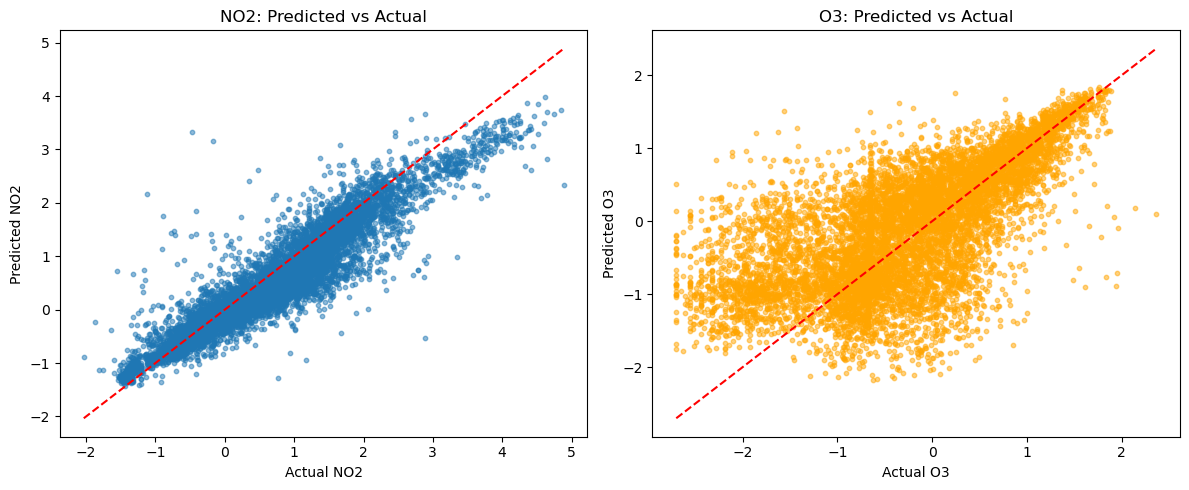

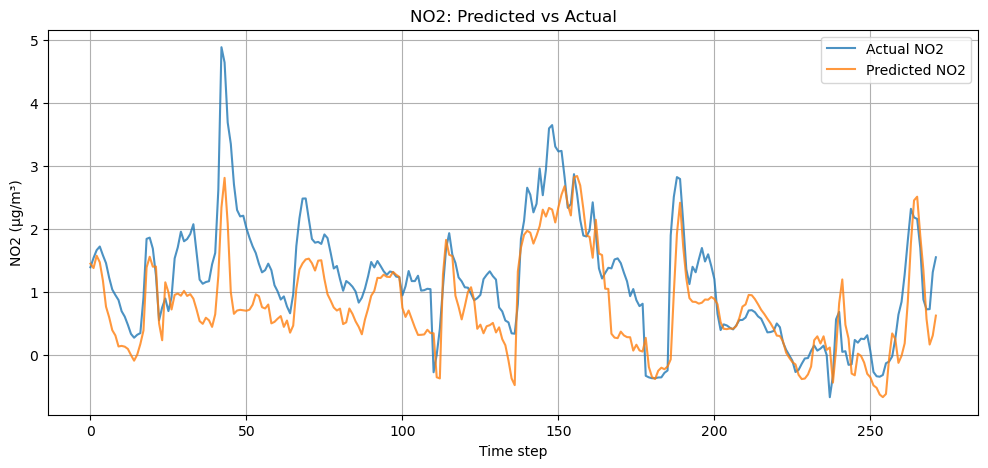

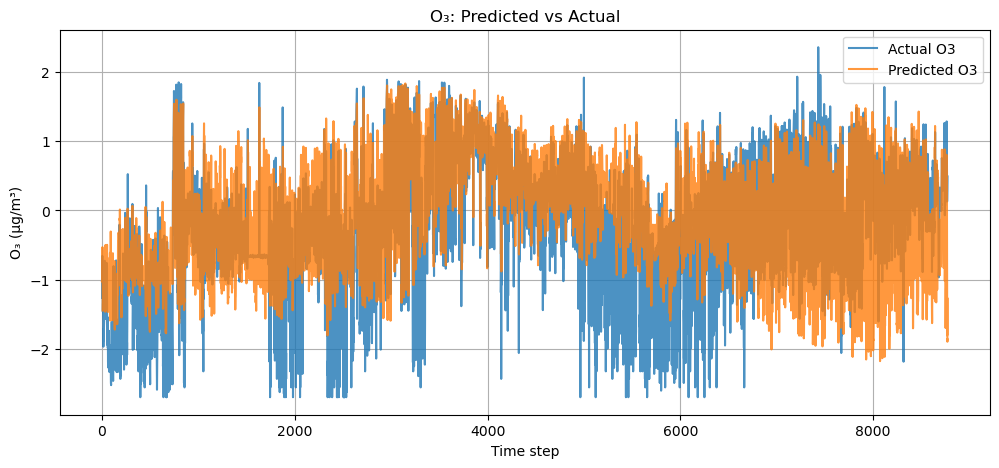

In [367]:
preds_all, labels_all = evaluate_and_plot(model, test_loader, device)
